In [56]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
sns.set()
#sns.set_style("whitegrid", {'axes.grid' : False})



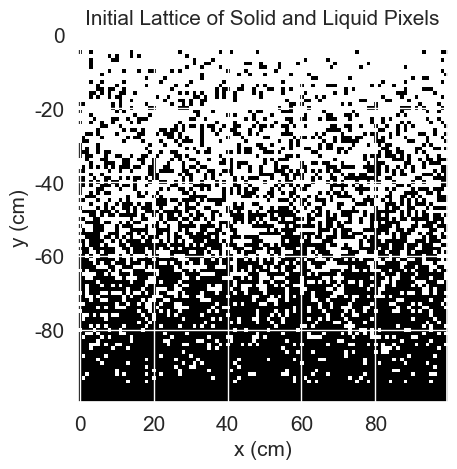

' perm_percent = 0.5\nnum_solid = int(perm_percent*N*N)\n\n\n# Location of solid pixels\nlattice = np.zeros(N*N, dtype=int)\nlattice[:num_solid] = 1\n\nnp.random.shuffle(lattice)\n\nlattice = lattice.reshape((len(x), len(x))) '

In [21]:
# Initialize Lattice
L = 1   
dx = 0.01 #mm resolution
x = np.arange(0, L, dx) # range [0, 1]
y = -x # range [1, 0] (depth)
N = len(x)
lattice = np.zeros((N, N))


#Stratified initial lattice

def assignSolid(perm_percent, Y):
    num_solid = int(perm_percent*N*Y)

    # Location of solid pixels
    lattice = np.zeros(N*Y)
    lattice[:num_solid] = 1

    np.random.shuffle(lattice)

    lattice = lattice.reshape((N, Y))
    return lattice


Y = int(N/10)

top = assignSolid(0, int(Y/2))

middle_1 = assignSolid(0.1, Y)
middle_2 = assignSolid(0.2, Y)
middle_3 = assignSolid(0.3, Y)
middle_4 = assignSolid(0.4, Y)
middle_5 = assignSolid(0.5, Y)
middle_6 = assignSolid(0.6, Y)
middle_7 = assignSolid(0.7, Y)
middle_8 = assignSolid(0.8, Y)
middle_9 = assignSolid(0.9, Y)


bottom = assignSolid(1, int(Y/2))



middle = np.concat((middle_1, middle_2, middle_3, middle_4, middle_5, middle_6, middle_7, middle_8, middle_9), axis=1)

lattice=np.append(top, middle, axis=1)
lattice = np.append(lattice, bottom, axis=1)
lattice = np.transpose(lattice)

plt.imshow(lattice, cmap="Greys", interpolation='none')
plt.title("Initial Lattice of Solid and Liquid Pixels", fontsize=15)
plt.xlabel("x (cm)", fontsize=15)
plt.ylabel("y (cm)", fontsize=15)
plt.yticks([0,  20, 40, 60, 80], [0, -20, -40, -60, -80], fontsize=15)
plt.xticks(fontsize=15)

plt.savefig('lattice.png')
plt.show()






# Assign Solid Pixels Randomly represented by a 1 in matrix

# Number of solid pixels
""" perm_percent = 0.5
num_solid = int(perm_percent*N*N)


# Location of solid pixels
lattice = np.zeros(N*N, dtype=int)
lattice[:num_solid] = 1

np.random.shuffle(lattice)

lattice = lattice.reshape((len(x), len(x))) """






(10000, 2)


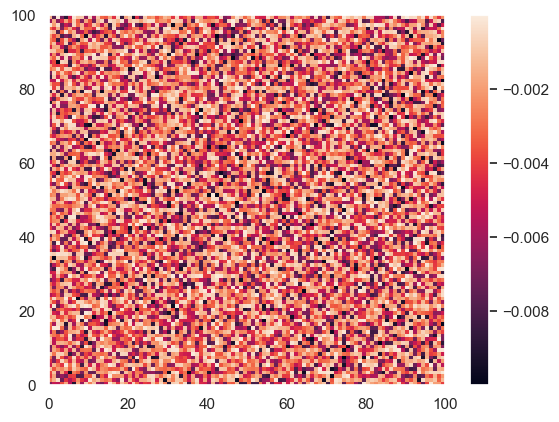

In [22]:
# Assign velocity vectors at each pixel
angle = np.random.uniform(np.pi, 2 * np.pi, size=(N* N , 2)) #generate angle in lower half plane (from pi to 2 pi)
direction = np.array([np.cos(angle[:,0]), np.sin(angle[:,1])]) # decompose into x and y components
direction= np.transpose(direction)
print(direction.shape)
magnitude = np.random.uniform(1, 10, size=(N*N)) * 10**-3 # randomly choose magnitude between 1 and 10 mm/s

#scale unit vectors
x_comp = magnitude*direction[:, 0]
x_comp=x_comp.reshape(N,N)

y_comp = magnitude*direction[:, 1]
y_comp=y_comp.reshape(N,N)
magnitude=magnitude.reshape(N,N)

velocities=np.array([x_comp, y_comp])


plt.figure()
plt.pcolor(y_comp)
plt.colorbar()







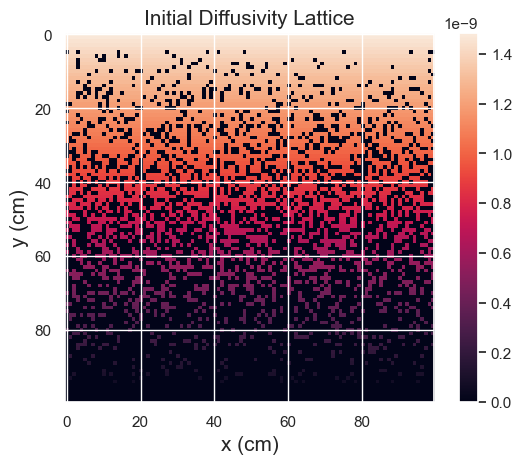

In [23]:

# Constants
kappa_d = 1.5 * 10 ** -7 # m^2 s^-1 water thermal diffusivity

# Calculate D0 at Each Pixel
D_0_vec = x * kappa_d * dx
D_0_vec = np.flip(D_0_vec)

D_0 = np.repeat(D_0_vec[np.newaxis,...], N, axis=0)
D_0 = D_0.transpose()
D_0[lattice > 0] = 0



plt.imshow(D_0, interpolation='none')
plt.title("Initial Diffusivity Lattice", fontsize=15)
#plt.xticks([0, 100, 150, 200])
plt.xlabel("x (cm)",  fontsize=15)
#plt.yticks([0,  10, 20, 30], [0, -10, -20, -30])
plt.ylabel("y (cm)",  fontsize=15)
plt.colorbar()
plt.savefig('diffusivity.png')






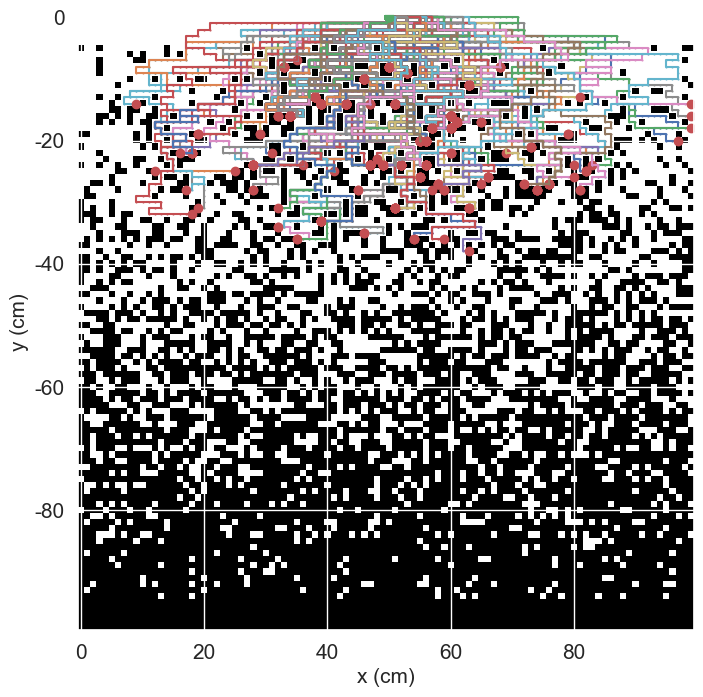

In [24]:
# Random Walk

def computeProbability(D_i, D_j, v_j, i, j, e_ij):
    #D_i is diffusivity at current location
    #D_j is diffusivity at new location
    #v_ij is velocity at pixel j (need to calculate direction of flow at pixel j in direction of i)
    #i is position of pixel i
    #j is position of pixel j
    #e_ij points from j -> i

    if lattice[j[0], j[1]] == 1:
        b = 0
    else:
        v_ij = v_j @ e_ij  # flow at pixel j in direction of i
        D_eij = (D_i*D_j)**0.5 #geometric mean of diffusivity at i and j
        b = D_eij + (np.linalg.norm(v_j) * 0.5 * (v_ij /  np.linalg.norm(v_ij) + 1)) # compute probability

    return b


def run_walk():
    i = 0
    j = int(N/2)
    position = np.array([i, j]) # start walk at center top of snow
    path = np.zeros((10000, 2))
    probabilities = np.zeros((10000, 3))
    moves = [''] * 10000


    keep_going = True
    k=0


    while(keep_going==True):
        left = lattice[i,j-1]
        right = lattice[i, j+1]
        down = lattice[i+1, j]
        states = np.array([left, right ,down])

        # check if current position is surrounded by solid pixels
        if(states.all()==1):
            #print("Walk terminated after ", k, " steps")
            break

        #compute probabilities 
        b_left = computeProbability(D_0[i, j], D_0[i, j-1], velocities[:, i, j-1], [i, j], [i, j-1], [1,0]) 
        b_right = computeProbability(D_0[i, j], D_0[i, j+1], velocities[:, i, j+1], [i, j], [i, j+1], [-1,0]) 
        b_down = computeProbability(D_0[i, j], D_0[i+1, j], velocities[:, i+1, j], [i, j], [i+1, j], [0,1])

        #Prevent the walk from moving backwards
        if(moves[k-1] == 'L' ):
            b_right = 0
        elif(moves[k-1] == 'R'):
            b_left = 0

        b_sum = b_left + b_right + b_down
        if (b_sum == 0):
            #print("Walk terminated")
            break

        P_left = b_left / b_sum
        P_right = b_right / b_sum
        P_down = b_down / b_sum

        probs = np.array([P_left, P_right, P_down])
        
        probabilities[k, 0], probabilities[k, 1], probabilities[k, 2] = P_left, P_right, P_down

        #sample the distrubution
        move = np.random.choice(["L", "R", "D"], 1, p=probs)
        moves[k] = move[0]
        
        # update the position
        if (move == "L"):
            j = j-1
        elif (move == "R"):
            j = j+1
        elif (move == "D"):
            i = i+1
        
        k=k+1
        path[k, 0], path[k, 1] = i, j #update path history

        # check if we are at a boundary. if so then terminate walk
        if (j == 0 or j == N-1 or i == N-1):
            #print("Walk terminated after ", k, " steps")
            break
    
    path[0,0] = 0
    path[0,1] = int(N/2)
    path = np.trim_zeros(path)
    return path
        

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(lattice, cmap="Greys")
plt.yticks([0,  20, 40, 60, 80], [0, -20, -40, -60, -80], fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("x (cm)", fontsize=15)
plt.ylabel("y (cm)", fontsize=15)

M = 1000

depths = np.zeros(M)
lengths = np.zeros(M)

for i in range(M):
    path = run_walk()
    depths[i] = path[-1, 1]
    lengths[i] = len(path)

    # Plot results of walk
    
    ax.plot(path[:, 1], path[:, 0], '-o', markersize=0.5, label='Path')
    ax.plot(path[0, 1], path[0, 0], 'go', label='Start')  # Start point
    ax.plot(path[-1, 1], path[-1, 0], 'ro', label='End')   # End point


plt.savefig('1000walks.svg')

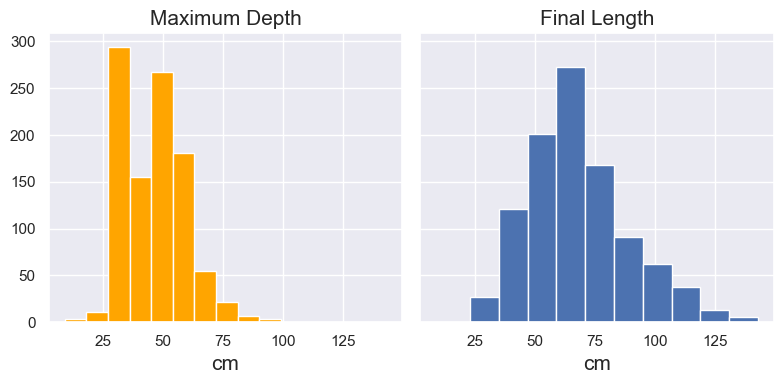

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].hist(depths, color='orange')
ax[1].hist(lengths)

ax[0].set_title("Maximum Depth", fontsize=15)
ax[1].set_title("Final Length", fontsize=15)
ax[0].set_xlabel("cm", fontsize = 15)
ax[1].set_xlabel("cm", fontsize = 15)
plt.tight_layout()

plt.savefig('histograms.png')





In [68]:
lengthsdf = pd.DataFrame(lengths)
depthsdf = pd.DataFrame(depths)

print(lengthsdf.describe())
depthsdf.describe()





                0
count  1000.00000
mean     67.55500
std      20.93818
min      23.00000
25%      53.00000
50%      65.00000
75%      78.00000
max     143.00000


,0
count,1000.00000
mean,45.89000
std,12.36312
min,9.00000
25%,34.00000
50%,46.00000
75%,55.00000
max,99.00000
